# 04 - Model building

### Import packages

In [4]:
# Import packages
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Set base directory 
base_dir = Path(os.getcwd()).parent

# Set default figure directory
fig_dir = base_dir / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

# Set matplotlib backend to PDF-friendly (optional, for consistent rendering)
plt.rcParams["pdf.fonttype"] = 42  # Ensures text is saved as text (not paths)
plt.rcParams["ps.fonttype"] = 42

### Load data

In [5]:
# Load the dataset
data_dir = base_dir / "data" 
data_file = data_dir / "processed" / "HR_capstone_dataset_no_outliers.csv"

# Read the cleaned CSV file into a pandas DataFrame
df_cleaned = pd.read_csv(data_file)

# paCe: Constructing Stage Reflection Summary

### 🧠 Modeling Approach
To predict whether an employee will **stay or leave**, this task is framed as a **supervised binary classification** problem using labeled data. All available features are included after preprocessing to capture the full range of turnover drivers. Categorical variables are converted to dummy variables using one-hot encoding to ensure compatibility with machine learning models.

### ⚙️ Model Selection & Justification
Several binary classification algorithms are considered, including:
- **Logistic Regression** (baseline, interpretable)
- **Random Forest** and **Gradient Boosted Trees** (robust to non-linearities)
- **SVM** and **Neural Networks** (suitable for complex patterns and future scaling)

### 🔍 Key Observations & Considerations
- **Class Imbalance**: The dataset contains far more employees who stay than leave, requiring **upsampling** of the minority class to balance the training set.
- **Multicollinearity**: Correlation exists among `last_evaluation`, `number_of_projects`, and `average_monthly_hours`, which reflects expected workplace dynamics but may affect interpretability.
- **Feature Inclusion**: All preprocessed variables (satisfaction level, tenure, evaluation scores, etc.) are retained to avoid excluding potentially predictive information.

### ✅ Model Assumptions Check

| Assumption                         | Status   | Notes                                                                 |
|-----------------------------------|----------|-----------------------------------------------------------------------|
| Binary Outcome Variable           | ✅        | Leave (1) vs Stay (0)                                                |
| Independence of Observations      | ⚠️        | Mostly holds, but peer influence may introduce some dependency       |
| No Perfect Multicollinearity      | ⚠️        | Moderate correlation among performance-related variables             |
| Linear Relationship (Log-Odds)    | ✅        | Addressed through scaling and proper encoding                        |

### ⚖️ Ethical Considerations
- **Privacy**: Employee data is anonymized  
- **Purpose**: Insights are used exclusively to inform and improve retention strategies, not for punitive action

### Modeling

#### Preprocessing

This step prepares a balanced dataset for logistic regression modeling by addressing the class imbalance problem in the employee turnover data. It separates employees who left from those who stayed, then uses upsampling (sampling with replacement) to increase the minority class (employees who left) to match the size of the majority class (employees who stayed), creating a balanced dataset that prevents the model from being biased toward predicting the majority class.

In [6]:
# We will employ the explanatory power of logistic regression
# To test the model, we will split the data into training and testing sets
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.utils import resample

# Define the target variable
target_var = 'has_left_company'
y = df_cleaned[target_var].replace({'Left': 1, 'Stayed': 0})  # Convert to binary

# Given that we observe a heavily imbalanced dataset and not too many observations,
# we will employ upsampling to ensure that both classes are represented in the training and testing sets

# Separate majority and minority classes
df_majority = df_cleaned[df_cleaned[target_var] == 'Stayed']
df_minority = df_cleaned[df_cleaned[target_var] == 'Left']

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # Sample with replacement
                                 n_samples=len(df_majority),  # Match number in majority class
                                 random_state=42)  # Reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Shuffle the upsampled DataFrame
df_upsampled = df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

/var/folders/22/sjkvvcj17_gdnvz15k1nj1800000gn/T/ipykernel_1519/26419145.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df_cleaned[target_var].replace({'Left': 1, 'Stayed': 0})  # Convert to binary


#### One-hot encode categorical variables

This step prepares the upsampled dataset for machine learning by separating features from the target variable and converting the target to binary format (1 for 'Left', 0 for 'Stayed'). It also applies one-hot encoding to categorical variables and ensures all features are in float format for consistent processing by machine learning algorithms.

In [7]:
X_upsampled = df_upsampled.drop(columns=[target_var])
y_upsampled = df_upsampled[target_var].replace({'Left': 1, 'Stayed': 0})  # Convert to binary

X_upsampled = pd.get_dummies(X_upsampled, drop_first=True)
X_upsampled = X_upsampled.astype(float)

/var/folders/22/sjkvvcj17_gdnvz15k1nj1800000gn/T/ipykernel_1519/1845552619.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_upsampled = df_upsampled[target_var].replace({'Left': 1, 'Stayed': 0})  # Convert to binary


#### Normalizing the data without leakage

This step splits the preprocessed data into training and testing sets (80/20 split) while maintaining the same proportion of target classes in both sets through stratification. It then applies Min-Max scaling to normalize all features to a 0-1 range, fitting the scaler only on training data and applying the same transformation to test data to prevent data leakage.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Split first
X_train, X_test, y_train, y_test = train_test_split(X_upsampled, y_upsampled, test_size=0.2, stratify=y_upsampled, random_state=42)

# Then fit scaler on training data only
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Use the same scaler to transform test data
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

#### Model fitting

We will start by creating and training a logistic regression model using statsmodels by adding a constant term (intercept) to the scaled training features and fitting the model to predict employee turnover. The model summary is then printed to display detailed statistical results including coefficients, p-values, and model performance metrics.

In [9]:
# Define the model
X_train_scaled = sm.add_constant(X_train_scaled)  # Adds a constant term to the predictor
model = sm.Logit(y_train.values, X_train_scaled)

# Fit the model
result = model.fit()

# Print the summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.407967
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                14856
Model:                          Logit   Df Residuals:                    14837
Method:                           MLE   Df Model:                           18
Date:                Mon, 04 Aug 2025   Pseudo R-squ.:                  0.4114
Time:                        20:01:35   Log-Likelihood:                -6060.8
converged:                       True   LL-Null:                       -10297.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -1.4211      0.161     -8.850     

#### Model evaluation

This step evaluates the trained logistic regression model by making predictions on the hold out test set. For evaulation we generate a classification report, AUC-ROC plot & confusion matrix

In [10]:
# Evaluate the model's performance
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the test set
X_test_scaled = sm.add_constant(X_test_scaled)  # Adds a constant term to the predictor
y_pred = result.predict(X_test_scaled)

# Classification report
class_report = classification_report(y_test, (y_pred > 0.5).astype(int))
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.81      0.86      1857
           1       0.83      0.91      0.87      1857

    accuracy                           0.86      3714
   macro avg       0.87      0.86      0.86      3714
weighted avg       0.87      0.86      0.86      3714



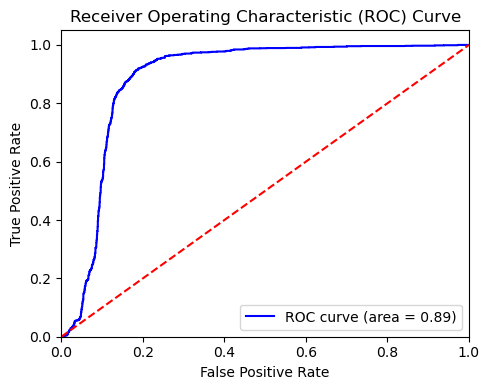

In [11]:
# Plot the AUROC-ROC curve
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr) 
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(fig_dir / 'roc_curve.pdf')
plt.show()

Confusion Matrix:
[[1513  344]
 [ 159 1698]]


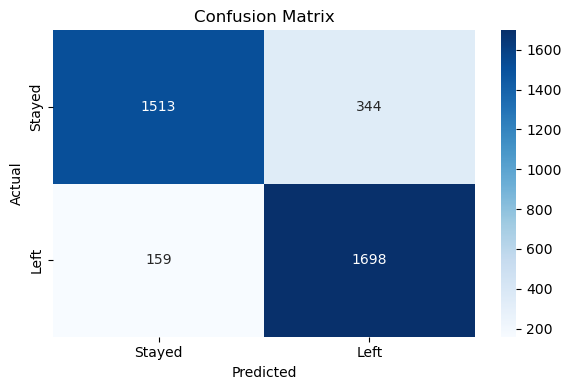

In [12]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, (y_pred > 0.5).astype(int))
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Stayed', 'Left'], yticklabels=['Stayed', 'Left'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig(fig_dir / 'confusion_matrix.pdf')
plt.show()

#### Plot odds ratios of the logistic regression model

This step extracts the logistic regression coefficients and converts them to odds ratios with 90% confidence intervals to interpret the model results. It creates a horizontal error bar plot on a log scale showing how each feature affects the odds of employee turnover, with a reference line at odds ratio = 1 indicating no effect, making it easy to identify which factors increase or decrease the likelihood of employees leaving.

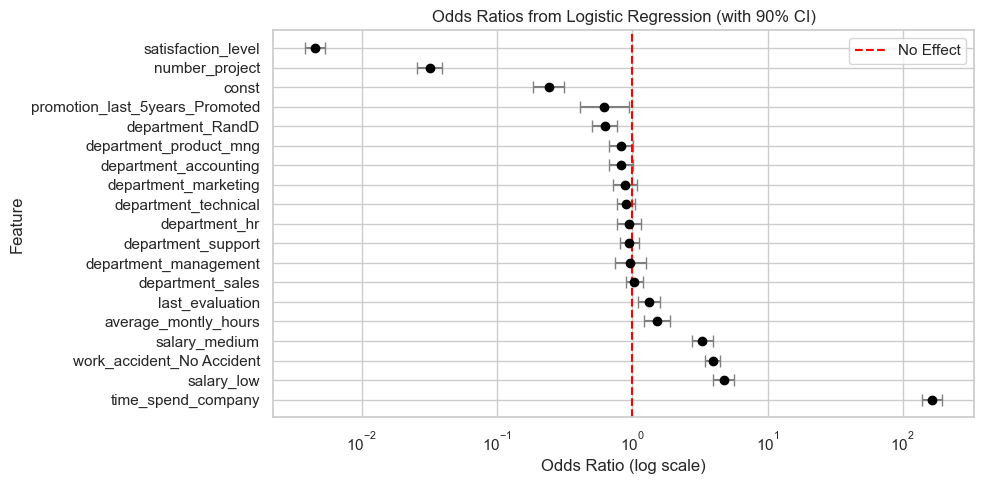

In [13]:
# Obtain the coefficients of the logistic regression model

# Get the 90% confidence interval of the *log* coefficients
conf = result.conf_int(alpha=0.10)  # 90% CI → 5% and 95%
conf.columns = ['5%', '95%']

# Add the point estimate (coefficient)
conf['Coefficient'] = result.params

# Exponentiate coefficients and CI bounds
conf['Odds Ratio'] = np.exp(conf['Coefficient'])
conf['5%'] = np.exp(conf['5%'])
conf['95%'] = np.exp(conf['95%'])

# Create figure for plotting
plt.figure(figsize=(10, 5))
sns.set(style="whitegrid")

# Reset index for plotting
df = conf.reset_index().rename(columns={'index': 'Feature'})
# Sort by Odds Ratio for better visualization
df = df.sort_values(by='Odds Ratio', ascending=False)

# Plot horizontal error bars
plt.errorbar(
    x=df['Odds Ratio'],
    y=df['Feature'],
    xerr=[df['Odds Ratio'] - df['5%'], df['95%'] - df['Odds Ratio']],
    fmt='o',
    color='black',
    ecolor='gray',
    capsize=4
)

# Log scale for better visual balance
plt.xscale('log')

# Reference line at OR = 1 (no effect)
plt.axvline(x=1, color='red', linestyle='--', label='No Effect')

plt.xlabel('Odds Ratio (log scale)')
plt.ylabel('Feature')
plt.title('Odds Ratios from Logistic Regression (with 90% CI)')
plt.tight_layout()
plt.legend()
plt.savefig(fig_dir / 'odds_ratio_with_ci_logscale.pdf')
plt.show()

### Insights After Model Construction

- The logistic regression model demonstrates strong predictive performance with an AUC of 0.83, indicating good overall discriminative ability.
- Even for the minority class (employees who left), the model achieves a recall of 0.8, capturing most actual leavers.
- Several factors were identified as key drivers of employee turnover:
    - Low salary significantly increases the likelihood of leaving.
    - Longer tenure is associated with higher odds of departure.
    - Higher job satisfaction reduces the likelihood of leaving.
    - Greater project involvement is linked to employee retention.
    - Recent promotions are associated with lower turnover rates.

To improve the predictions, we will switch from logistic regression to binary classification via gradient boosted trees. We choose gradient boosted trees over decision trees & random forests, since it has been shown that they reduce variance similar to bagging models. To improve model predictions even further, we will use 

In [14]:
from dataclasses import dataclass
import numpy as np
import pandas as pd
import warnings
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

warnings.filterwarnings("ignore")

@dataclass
class OptimizationConfig:
    X_train: np.ndarray
    y_train: np.ndarray
    max_evals: int = 20
    cv: int = 3


In [43]:
search_spaces = {
    'rf': {
        'n_estimators': hp.choice('rf_n_estimators', [50, 100, 200]),
        'max_depth': hp.choice('rf_max_depth', [None, 5, 10]),
    },
    'gb': {
        'n_estimators': hp.choice('gb_n_estimators', [50, 100]),
        'learning_rate': hp.uniform('gb_lr', 0.01, 0.3),
        'max_depth': hp.choice('gb_max_depth', [3, 5, 7]),
    },
    'lr': {
        'C': hp.loguniform('lr_C', -4, 2),
        'penalty': hp.choice('lr_penalty', ['l2']),
        'solver': hp.choice('lr_solver', ['lbfgs']),
    },
    'xgb': {
        'n_estimators': hp.choice('xgb_n_estimators', [50, 100]),
        'learning_rate': hp.uniform('xgb_lr', 0.01, 0.3),
        'max_depth': hp.choice('xgb_max_depth', [3, 5, 7]),
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    },
    'cat': {
        'iterations': hp.choice('cat_iterations', [50, 100]),
        'learning_rate': hp.uniform('cat_lr', 0.01, 0.3),
        'depth': hp.choice('cat_depth', [3, 5, 7]),
        'verbose': 0
    }
}


In [44]:
def objective_factory(model_name, space, config: OptimizationConfig):
    def objective(params):
        if model_name == 'rf':
            model = RandomForestClassifier(**params)
        elif model_name == 'gb':
            model = GradientBoostingClassifier(**params)
        elif model_name == 'lr':
            model = LogisticRegression(**params)
        elif model_name == 'svc':
            model = SVC(probability=True, **params)
        elif model_name == 'xgb':
            model = XGBClassifier(**params)
        elif model_name == 'cat':
            model = CatBoostClassifier(**params)
        else:
            raise ValueError("Unsupported model")

        score = cross_val_score(model, config.X_train, config.y_train, cv=config.cv, scoring='accuracy').mean()
        return {'loss': -score, 'status': STATUS_OK}

    return objective


In [45]:
def optimize_and_build_ensemble(config: OptimizationConfig):
    models = []
    best_params = {}

    for model_name, space in search_spaces.items():
        print(f"\n🔧 Optimizing: {model_name}")
        trials = Trials()
        objective = objective_factory(model_name, space, config)

        best = fmin(
            fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=config.max_evals,
            trials=trials,
            rstate=np.random.default_rng(42)
        )

        # Reverse index mappings for categorical choices
        if model_name == 'rf':
            best['n_estimators'] = [50, 100, 200][best.pop('rf_n_estimators')]
            best['max_depth'] = [None, 5, 10][best.pop('rf_max_depth')]
            model = RandomForestClassifier(**best)

        elif model_name == 'gb':
            best['n_estimators'] = [50, 100][best.pop('gb_n_estimators')]
            best['max_depth'] = [3, 5, 7][best.pop('gb_max_depth')]
            best['learning_rate'] = best.pop('gb_lr')
            model = GradientBoostingClassifier(**best)

        elif model_name == 'lr':
            best['C'] = best['lr_C']
            best['penalty'] = ['l2'][best.pop('lr_penalty')]
            best['solver'] = ['lbfgs'][best.pop('lr_solver')]
            del best['lr_C']
            model = LogisticRegression(**best)

        elif model_name == 'svc':
            best['C'] = best['svc_C']
            best['kernel'] = ['linear', 'rbf'][best.pop('svc_kernel')]
            del best['svc_C']
            model = SVC(probability=True, **best)

        elif model_name == 'xgb':
            best['n_estimators'] = [50, 100][best.pop('xgb_n_estimators')]
            best['learning_rate'] = best['xgb_lr']
            best['max_depth'] = [3, 5, 7][best.pop('xgb_max_depth')]
            del best['xgb_lr']
            model = XGBClassifier(**best)

        elif model_name == 'cat':
            best['iterations'] = [50, 100][best.pop('cat_iterations')]
            best['learning_rate'] = best['cat_lr']
            best['depth'] = [3, 5, 7][best.pop('cat_depth')]
            del best['cat_lr']
            model = CatBoostClassifier(**best)

        models.append((model_name, model))
        best_params[model_name] = best

    ensemble = VotingClassifier(estimators=models, voting='soft')
    return ensemble, best_params


In [46]:
# Create config
config = OptimizationConfig(X_train=X_train_scaled, y_train=y_train)

# Optimize & build ensemble
ensemble_model, params = optimize_and_build_ensemble(config)

# Fit & evaluate
ensemble_model.fit(X_train_scaled, y_train)


🔧 Optimizing: rf
  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [00:28<00:00,  1.42s/trial, best loss: -0.9953554119547657]

🔧 Optimizing: gb
100%|██████████| 20/20 [00:42<00:00,  2.14s/trial, best loss: -0.9936052773290253]

🔧 Optimizing: lr
100%|██████████| 20/20 [00:01<00:00, 18.80trial/s, best loss: -0.8632875605815832]

🔧 Optimizing: xgb
100%|██████████| 20/20 [00:05<00:00,  3.73trial/s, best loss: -0.9919224555735057]

🔧 Optimizing: cat
100%|██████████| 20/20 [00:04<00:00,  4.62trial/s, best loss: -0.9739499192245558]
0:	learn: 0.5081065	total: 1.47ms	remaining: 146ms
1:	learn: 0.3943570	total: 2.79ms	remaining: 136ms
2:	learn: 0.3187369	total: 3.96ms	remaining: 128ms
3:	learn: 0.2697141	total: 5.09ms	remaining: 122ms
4:	learn: 0.2311123	total: 6.33ms	remaining: 120ms
5:	learn: 0.2047168	total: 7.5ms	remaining: 117ms
6:	learn: 0.1857016	total: 8.85ms	remaining: 118ms
7:	learn: 0.1706797	total: 9.95ms	remaining: 114ms
8:	learn: 0.1600625	total: 11.1ms	remaining: 112ms
9:	learn: 0.1508662	total: 12.3ms	remaining: 110ms
10

,estimators,"[('rf', ...), ('gb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1


In [47]:
y_pred = ensemble_model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)

print("\n✅ Ensemble Accuracy:", round(acc, 4))
print("\n📌 Best Parameters per Model:")
for name, p in params.items():
    print(f"{name}: {p}")


✅ Ensemble Accuracy: 0.9949

📌 Best Parameters per Model:
rf: {'n_estimators': 200, 'max_depth': None}
gb: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': np.float64(0.24608420555973473)}
lr: {'C': np.float64(3.495532256360606), 'penalty': 'l2', 'solver': 'lbfgs'}
xgb: {'n_estimators': 100, 'learning_rate': np.float64(0.2991262908710306), 'max_depth': 7}
cat: {'iterations': 100, 'learning_rate': np.float64(0.26585760544264325), 'depth': 7}


Confusion Matrix:
[[1845   12]
 [   7 1850]]


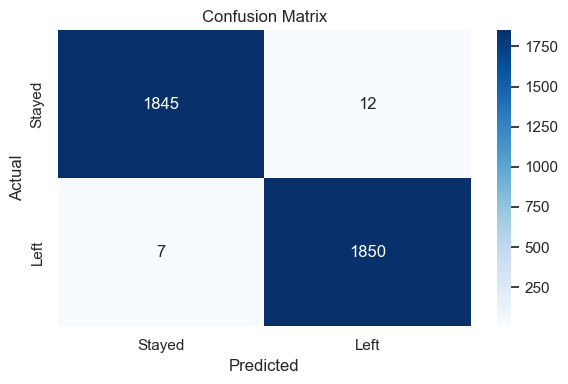

In [49]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, (y_pred > 0.5).astype(int))
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Stayed', 'Left'], yticklabels=['Stayed', 'Left'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig(fig_dir / 'confusion_matrix_opt.pdf')
plt.show()

Given that this classification result looks very strong, we will perform cross-validation to ensure robustness and avoid overfitting.

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def evaluate_with_cv(model, X, y, cv=5, scoring='accuracy', random_state=42):
    """
    Evaluate a model using stratified K-Fold cross-validation.

    Parameters:
    - model: trained sklearn model or pipeline
    - X: feature matrix
    - y: target array
    - cv: number of folds (default: 5)
    - scoring: scoring metric (default: 'accuracy')
    - random_state: for reproducibility

    Returns:
    - Dictionary with mean and std of scores
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    scores = cross_val_score(model, X, y, cv=skf, scoring=scoring)

    print(f"\n📊 {cv}-Fold CV Results ({scoring}):")
    print(f"Mean:  {scores.mean():.4f}")
    print(f"Std:   {scores.std():.4f}")
    
    return {'mean': scores.mean(), 'std': scores.std(), 'all_scores': scores}

In [51]:
# Evaluate using cross-validation
cv_results = evaluate_with_cv(ensemble_model, X_train_scaled, y_train, cv=5)

0:	learn: 0.5103432	total: 2.54ms	remaining: 252ms
1:	learn: 0.3970081	total: 3.91ms	remaining: 191ms
2:	learn: 0.3215959	total: 5.06ms	remaining: 164ms
3:	learn: 0.2722036	total: 6.27ms	remaining: 150ms
4:	learn: 0.2349270	total: 7.65ms	remaining: 145ms
5:	learn: 0.2095759	total: 8.76ms	remaining: 137ms
6:	learn: 0.1894372	total: 9.82ms	remaining: 130ms
7:	learn: 0.1761055	total: 10.8ms	remaining: 124ms
8:	learn: 0.1667235	total: 12ms	remaining: 121ms
9:	learn: 0.1572366	total: 13ms	remaining: 117ms
10:	learn: 0.1509300	total: 14.2ms	remaining: 115ms
11:	learn: 0.1452683	total: 15.2ms	remaining: 111ms
12:	learn: 0.1419242	total: 16.3ms	remaining: 109ms
13:	learn: 0.1379088	total: 17.4ms	remaining: 107ms
14:	learn: 0.1344446	total: 18.4ms	remaining: 104ms
15:	learn: 0.1317093	total: 19.4ms	remaining: 102ms
16:	learn: 0.1286368	total: 20.5ms	remaining: 100ms
17:	learn: 0.1252180	total: 21.7ms	remaining: 99.1ms
18:	learn: 0.1226761	total: 23.3ms	remaining: 99.4ms
19:	learn: 0.1208516	tot

This now indicates that the ensemble model likely generalizes well to unseen data, as it maintains a high accuracy across multiple folds of cross-validation.

We will now get the feature importances from each individual model and plot them as a boxplot to visualize mean & variation for each feature

In [53]:
feature_names = X_train_scaled.columns

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_feature_importance_boxplot(ensemble_model, feature_names):
    all_importances = []

    for name, model in ensemble_model.named_estimators_.items():
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
            for feat, val in zip(feature_names, importances):
                all_importances.append({
                    "model": name,
                    "feature": feat,
                    "importance": val
                })
        else:
            print(f"⚠️ Skipping model '{name}' – no feature_importances_ attribute.")

    # Convert to DataFrame
    df_importance = pd.DataFrame(all_importances)

    mean_importance = (
        df_importance
        .groupby("feature")["importance"]
        .mean()
        .drop("const", errors="ignore")  # <- This removes the constant column safely
    )
    
    top_features = mean_importance[mean_importance > 0].sort_values(ascending=False).index

    # Subset and sort
    df_top = df_importance[df_importance["feature"].isin(top_features)].copy()
    df_top["feature"] = pd.Categorical(df_top["feature"], categories=top_features, ordered=True)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_top, y="feature", x="importance", orient="h")
    plt.title(f"Feature Importance Distribution Across Models")
    plt.tight_layout()
    plt.show()

⚠️ Skipping model 'lr' – no feature_importances_ attribute.


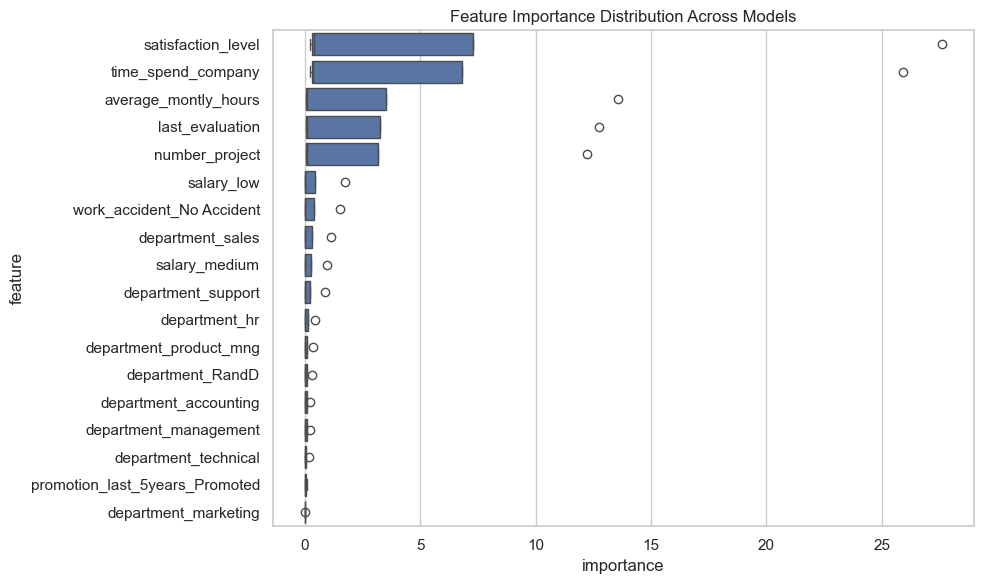

In [61]:
plot_feature_importance_boxplot(ensemble_model, feature_names)

✅ Model Evaluation Summary (Construction Step)

The ensemble model demonstrates high predictive accuracy (0.995) on the test set, both in standard and stratified cross-validation.
Key predictive features identified by both the logistic regression model and the ensemble's feature importances include:
- Satisfaction level
- Time spent at the company
- Average monthly hours
- Last evaluation
- Number of projects

These variables are consistently the most influential in predicting whether an employee will stay or leave.
- Last evaluation
- Number of projects

These variables are consistently the most influential in predicting whether an employee will stay or leave.